# Data Scientist Professional Case Study

### Company Background

Tasty Bytes , an online recipe startup, has hired you as a data scientist. The website features new recipes on the homepage every day. The owner has told you that on days that they feature a popular recipe, traffic increases by as much as 40%. However, it is difficult to predict in advance which recipes will be popular.

Recipes are considered to be popular if they receive a high score. The data team has collected data from previously published recipes.



### Customer Question

The owner wants to know:
- Can you use information on previously published recipes to predict whether a recipe will receive a high score?




### Success Criteria

The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. They want to know how your approach compares to this.


### Dataset

The data you will use for this analysis can be accessed here: `"data/recipes.csv"`

In [78]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

Exploratory Data Analysis

In [79]:
# read csv file and print summary statistics
df = pd.read_csv("data/recipes.csv")
display(df.describe())

RecipeId      Calories  CholesterolContent  CarbohydrateContent  \
count   43092.000000  43092.000000        43092.000000         43092.000000   
mean   224707.928154    353.297587           69.475757            32.844187   
std    141980.914350    405.065683          112.422309            46.428258   
min        38.000000      0.000000            0.000000             0.000000   
25%    102616.750000    164.800000            4.500000            11.600000   
50%    212333.000000    284.100000           40.700000            25.400000   
75%    336736.250000    446.725000           95.900000            43.400000   
max    540876.000000  30933.400000         9167.200000          3564.400000   

       SugarContent  ProteinContent  RecipeServings     HighScore  
count  43092.000000    43092.000000    43092.000000  43092.000000  
mean      12.206600       15.773125        9.517521      0.645735  
std       28.304371       21.588594      224.022873      0.478296  
min        0.000000        0.000000        1.000000      0.000000  
25%        2.200000        3.400000        4.000000      0.000000  
50%        5.500000        8.800000        6.000000      1.000000  
75%       14.100000       24.300000        8.000000      1.000000  
max     2566.800000     1420.800000    32767.000000      1.000000

Calories, CholesterolContent, CarbohydrateContent, SugarContent, ProteinContent, and RecipeServing might have many outliers on the higher end due to mean being on the lower end of the respective feature range. No negative numbers which shows no errors in data so far

#### Data Validation

In [80]:
# data type check
df.dtypes

RecipeId                 int64
Name                    object
RecipeCategory          object
Calories               float64
CholesterolContent     float64
CarbohydrateContent    float64
SugarContent           float64
ProteinContent         float64
RecipeServings         float64
HighScore              float64
dtype: object

Recipecategory will be converted to dummy variables \
RecipeServings and HighScore need integar data type \
Name will not be used in model. Can stay as object \

In [81]:
# convert to correct data type
df['RecipeServings'] = df['RecipeServings'].astype(int)
df['HighScore'] = df['HighScore'].astype(int)

In [82]:
# check features data types
df.dtypes

RecipeId                 int64
Name                    object
RecipeCategory          object
Calories               float64
CholesterolContent     float64
CarbohydrateContent    float64
SugarContent           float64
ProteinContent         float64
RecipeServings           int64
HighScore                int64
dtype: object

In [83]:
# convert CholesterolContent from milligrams to grams
df['CholesterolContent'] = df['CholesterolContent'] / 1000.

Now we have consistent units in all features

In [84]:
# confirm change has been applied
df['CholesterolContent'].describe()

count    43092.000000
mean         0.069476
std          0.112422
min          0.000000
25%          0.004500
50%          0.040700
75%          0.095900
max          9.167200
Name: CholesterolContent, dtype: float64

In [85]:
#Range validation
df.nlargest(n=10, columns=['ProteinContent'])

RecipeId                                               Name  \
38947    195512                                      Pork Sandwich   
32716    202651  Lemon Grass Prawn (Shrimp) Skewers With Mango ...   
35927      4341                              Hot Chocolate Dry Mix   
27970    267015                         Maple Apple Roasted Turkey   
40344    148446                         Seasoned Goldfish Crackers   
12067    197964           Creamy Sirloin, Mushroom and Barley Soup   
25891    439202                        P90x Island Pork Tenderloin   
24307      7201                                         Wild Goose   
41348    103176  Beer-braised Ribs in Barbecue Sauce (pressure ...   
26753    352050                             Zingy Chicken Stir-Fry   

         RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
38947      Lunch/Snacks   11249.0              4.2511                 39.4   
32716        Australian    6638.5              9.1672                 61.5   
35927         Beverages   25248.7              3.9731               2700.9   
27970      Whole Turkey   11670.9              4.2222                254.0   
40344  Toddler Friendly   30933.4              0.7961               3564.4   
12067              Meat    5196.1              1.8712                 28.5   
25891    Very Low Carbs    2501.1              1.3130                 14.5   
24307             Goose    5459.8              1.4196                107.2   
41348              Pork    4004.3              1.5155                 25.9   
26753     One Dish Meal   10057.1              2.1767               1804.3   

       SugarContent  ProteinContent  RecipeServings  HighScore  
38947           9.9          1420.8               1          1  
32716           5.5          1219.5               8          0  
35927        2566.8          1122.6               1          1  
27970         174.1          1112.9               1          0  
40344          17.2           618.6              10          1  
12067           3.4           498.8               6          1  
25891          13.4           417.4               4          1  
24307          56.9           412.7               1          1  
41348          16.3           396.5               4          0  
26753          68.2           387.8               2          1

Range for Calories, CholesterolContent, CarbohydrateContent, SugarContent, ProteinContent, and RecipeServing are not negative \
RecipeServing lowest value is 1 which show a good minimum value. \
Calories, CholesterolContent, CarbohydrateContent, SugarContent, ProteinContent, and RecipeServing have a higher than normal max. 
This is due to outliers that will be handled during data cleaning. \
For example the daily calorie intake for a male is around 2,500 calories. The largest calorie value in the dataframe is 30933 calories for one serving of seasoned goldfish crackers. This is impossible. \
Another example is for a pork sandwhich there is around 25 grams of protein per serving, but in the dataframe a porksandwhich contains 1420 grams per serving which is impossible

#### Data Cleaning

In [86]:
# Removing missing values
print(f'Shape of DataFrame: {df.shape}')
print(f'Number of null values in each feature: \n{df.isnull().sum()}')

Shape of DataFrame: (43092, 10)
Number of null values in each feature: 
RecipeId                0
Name                    0
RecipeCategory         40
Calories                0
CholesterolContent      0
CarbohydrateContent     0
SugarContent            0
ProteinContent          0
RecipeServings          0
HighScore               0
dtype: int64


In [87]:
# Drop 40 null values in RecipeCategory feature
df.dropna(subset="RecipeCategory", how='any', inplace=True)
# Check null values again
print(f'Number of null values in each feature: \n{df.isnull().sum()}')
print(f'Shape of DataFrame After Dropping na values: {df.shape}')

Number of null values in each feature: 
RecipeId               0
Name                   0
RecipeCategory         0
Calories               0
CholesterolContent     0
CarbohydrateContent    0
SugarContent           0
ProteinContent         0
RecipeServings         0
HighScore              0
dtype: int64
Shape of DataFrame After Dropping na values: (43052, 10)


In [88]:
# rows with no valueable information
zero_observations = (df["Calories"] == 0) & (df["CholesterolContent"] == 0) & (df["ProteinContent"] == 0) & (df["CarbohydrateContent"] == 0) & (df["SugarContent"] == 0)
print(f'{df[zero_observations].value_counts().sum()} observations with 0 for most numeric features')

188 observations with 0 for most numeric features


In [89]:
df[zero_observations]

RecipeId                                               Name  \
283      103014  Espresso Without a Machine Using a Single Serv...   
711      251628                   Serviette/Napkin, from the Heart   
878       66525                            Raisinet Banana Muffins   
905      291893                                          Irish Ice   
961      375040  Sweet Tea Vodka Cocktail (Aka: My Perfect Summ...   
...         ...                                                ...   
41515    256567                         Popcorn (Paper Bag Method)   
42118    197949                                   Ciclon Margarita   
42146    279076                           Drought Breaker Mocktail   
42365     67104                            Carol's EASY FISH TACOS   
42962    263420            The Perfect Pot and Cup of English Tea!   

        RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
283          Smoothies       0.0                 0.0                  0.0   
711          < 15 Mins       0.0                 0.0                  0.0   
878       Quick Breads       0.0                 0.0                  0.0   
905    Frozen Desserts       0.0                 0.0                  0.0   
961          Beverages       0.0                 0.0                  0.0   
...                ...       ...                 ...                  ...   
41515     Lunch/Snacks       0.0                 0.0                  0.0   
42118        Beverages       0.0                 0.0                  0.0   
42146        Beverages       0.0                 0.0                  0.0   
42365          Mexican       0.0                 0.0                  0.0   
42962        Beverages       0.0                 0.0                  0.0   

       SugarContent  ProteinContent  RecipeServings  HighScore  
283             0.0             0.0               2          0  
711             0.0             0.0               2          0  
878             0.0             0.0              12          0  
905             0.0             0.0               4          0  
961             0.0             0.0               1          1  
...             ...             ...             ...        ...  
41515           0.0             0.0               1          1  
42118           0.0             0.0               1          0  
42146           0.0             0.0               1          1  
42365           0.0             0.0               4          0  
42962           0.0             0.0               2          1  

[188 rows x 10 columns]

After further inspection it is decided that observations with value 0 for 5 out of the 6 features serves no valueable information and will be removed from dataframe. \
For example it is impossible for foods and beverages other than water to have zero calories in it. Having 0 for most features will confuse the model since no information is given for most of the features.

In [90]:
df.drop(df.loc[zero_observations].index, inplace=True)
print(f'{df[zero_observations].value_counts().sum()} observations with 0 for most numeric features')
print(f'New DF shape: {df.shape}')

0 observations with 0 for most numeric features
New DF shape: (42864, 10)


In [91]:
neg = (df[['CholesterolContent', 'CarbohydrateContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Calories']].values < 0).any().sum()
print(f'There are {neg} Observations with negative values in any features')

There are 0 Observations with negative values in any features


In [92]:
# check if there are duplicates in df
dup = df.duplicated().sum()
print(f'There are {dup} duplicated observations in the dataframe')
# df.drop_duplicates(inplace=True)

There are 0 duplicated observations in the dataframe


#### Data Visualization

In [93]:
# Define functions used below
def box_dist_plots(data):
    """Make box plots and dist plots of data"""
    Name=data.name.upper()
    mean=data.mean()
    median=data.median()
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle("SPREAD OF DATA FOR " + Name)
    sns.boxplot(x=data, data=data, ax=ax1)
    sns.distplot(data, ax=ax2)
    # create mean and median line on histogram plot
    ax2.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax2.axvline(median, color='g', linestyle='-',linewidth=2)
    plt.legend({'Mean': mean, 'Median': median})
    
def dist_plots(data):
    """Make box plots and dist plots of data"""
    Name=data.name.upper()
    mean=data.mean()
    median=data.median()
    fig, ax = plt.subplots()
    fig.suptitle("SPREAD OF DATA FOR " + Name)
    sns.distplot(data, ax=ax)
    # create mean and median line on histogram plot
    ax.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax.axvline(median, color='g', linestyle='-',linewidth=2)
    plt.legend({'Mean': mean, 'Median': median})

def box_plots(data):
    """Make box plots and dist plots of data"""
    Name=data.name.upper()
    fig, ax = plt.subplots()
    fig.suptitle("SPREAD OF DATA FOR " + Name)
    sns.boxplot(x=data, data=
data, ax=ax)
    
def qqplot(data):
    """Make qq plots of data"""
    Name=data.name.upper()
    fig = sm.qqplot(data)
    fig.suptitle("SPREAD OF DATA FOR " + Name)

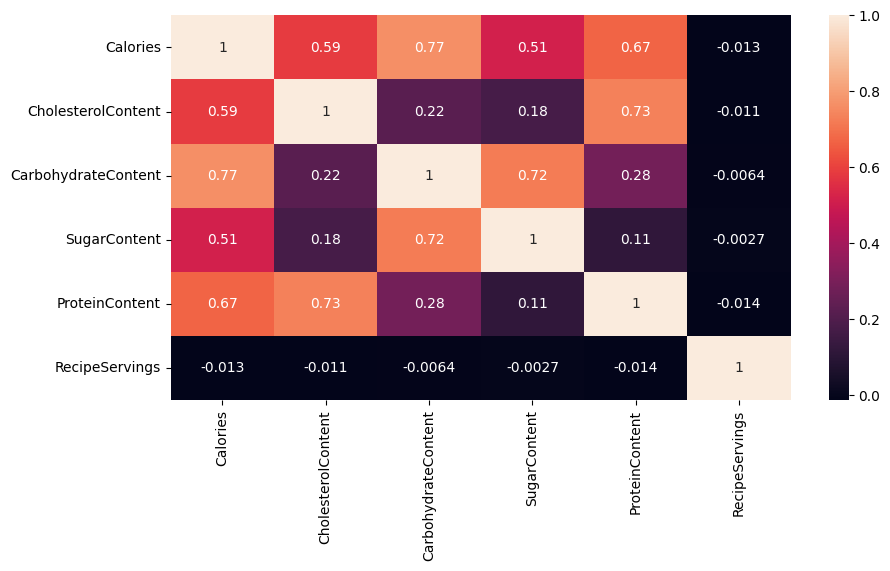

In [94]:
# Get features with numeric data
numeric_data = df.drop(['Name', 'RecipeId', 'RecipeCategory', 'HighScore'], axis=1)
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

Seems that recipe servings has no real correlation when compared with other features. Some features are highly correlated but not enough to be able to say one feature can explain another. Highest correlation is between calories and carbohydrates which makes sense because as calories increases the amount of carbs should also increase, but some foods are low in carbs and high in calories. 

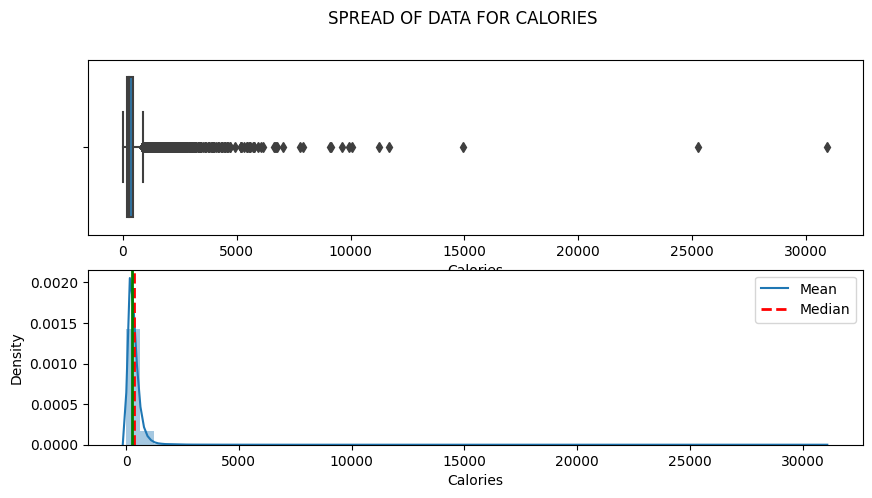

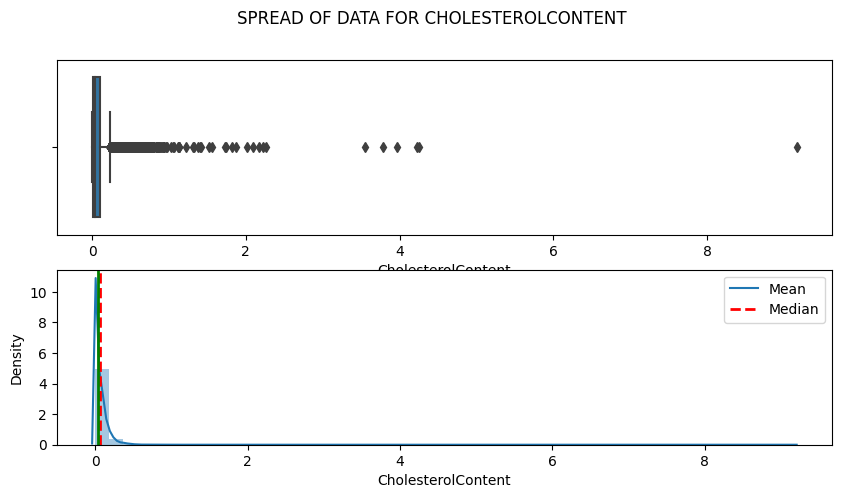

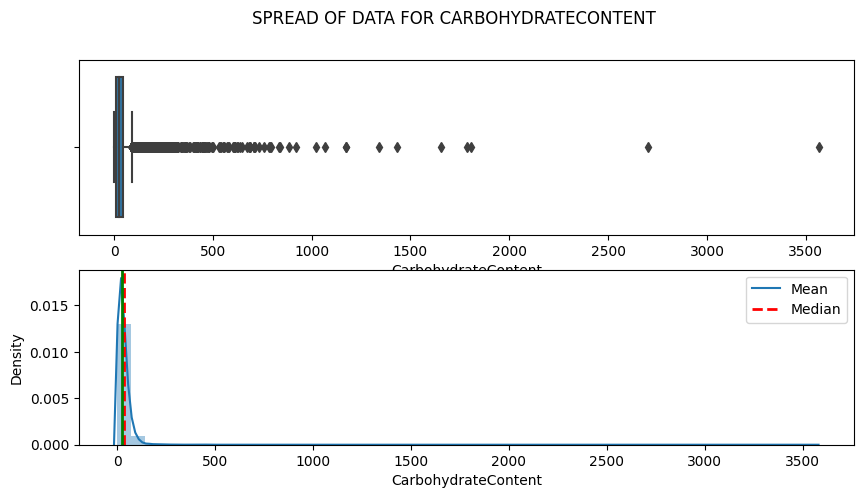

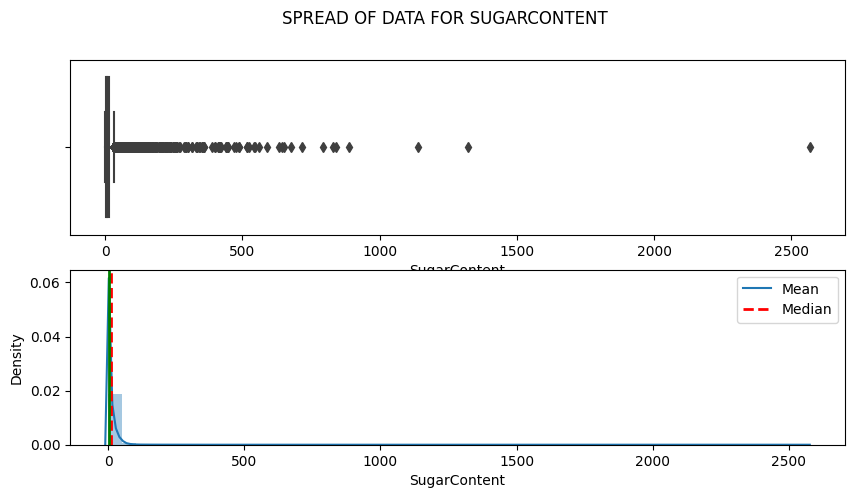

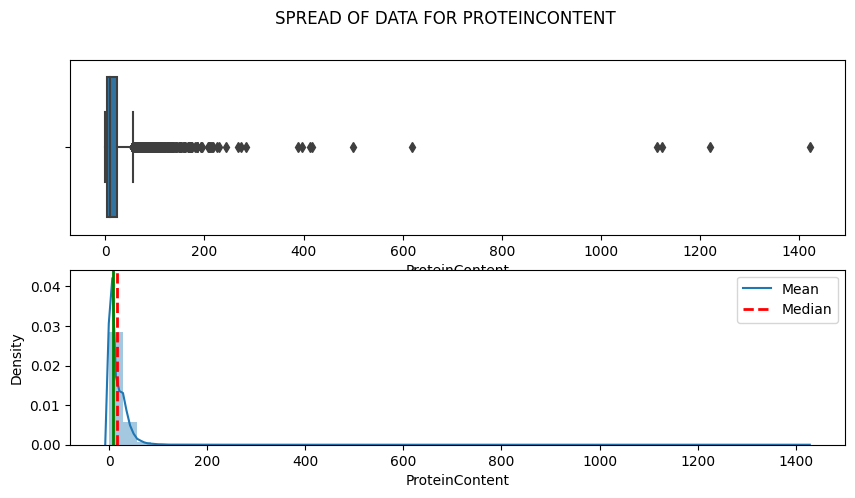

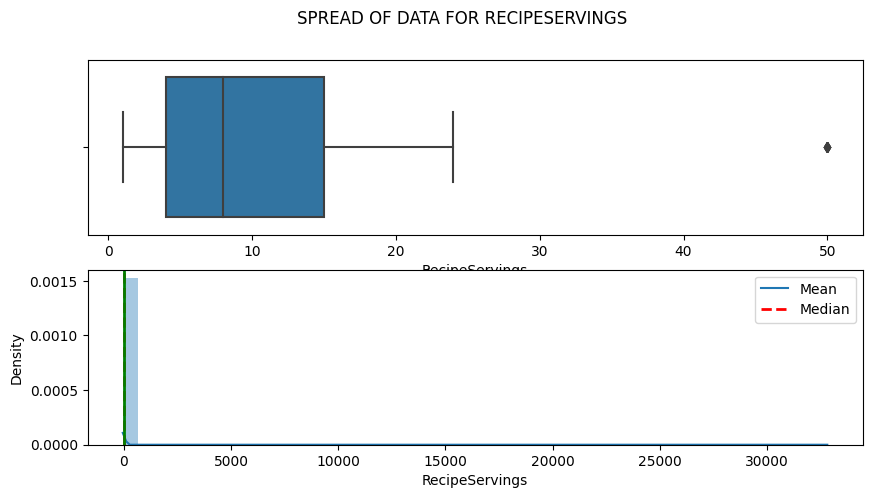

In [95]:
# Call box_hist_plot function by iterating over numeric features
numeric_columns = numeric_data.columns
for i in range(len(numeric_columns)):
    box_dist_plots(df[numeric_columns[i]])

Numeric data has many outliers and all features seem to be right skewed. Outliers may be significant so they can not be dropped until further evualuation. 

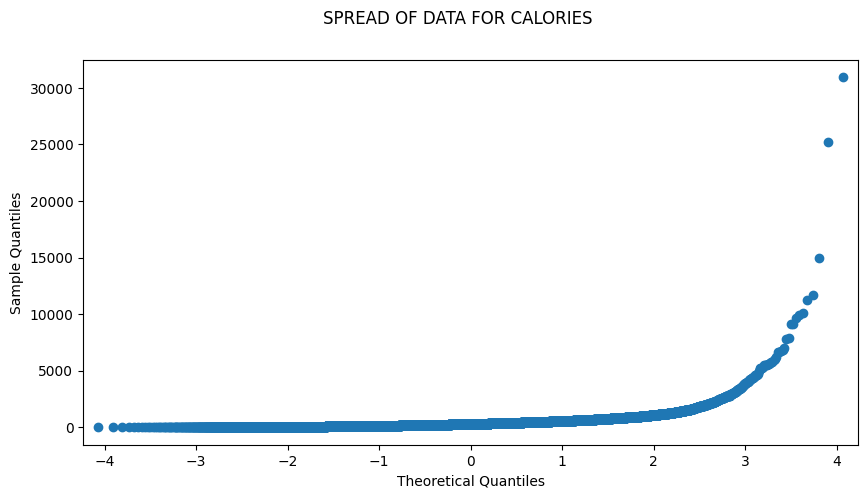

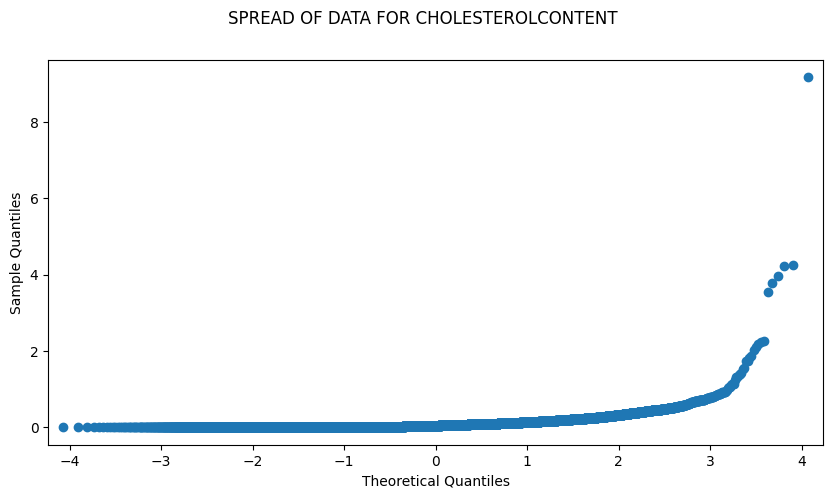

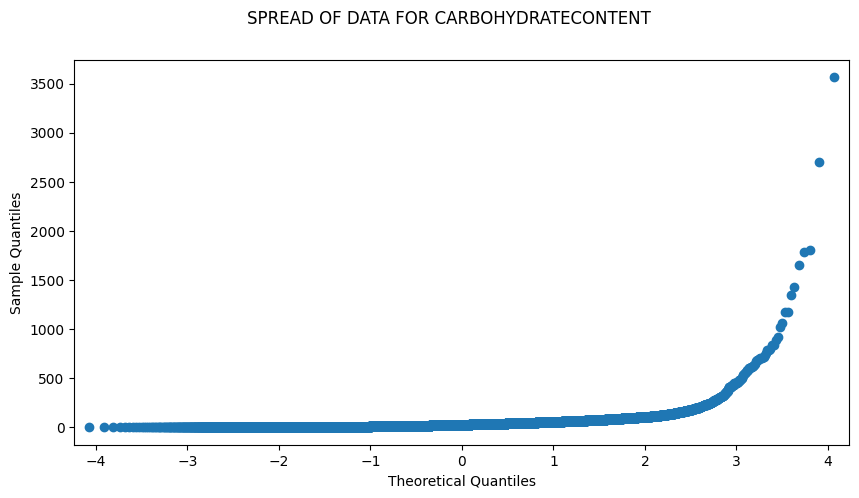

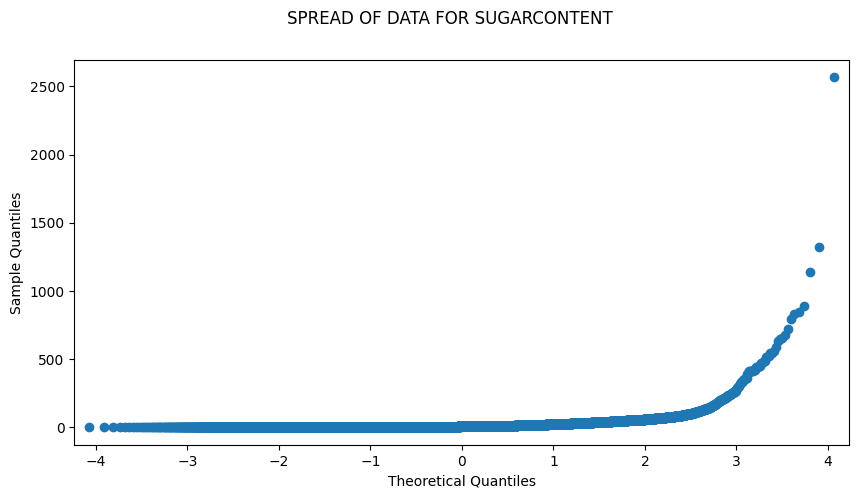

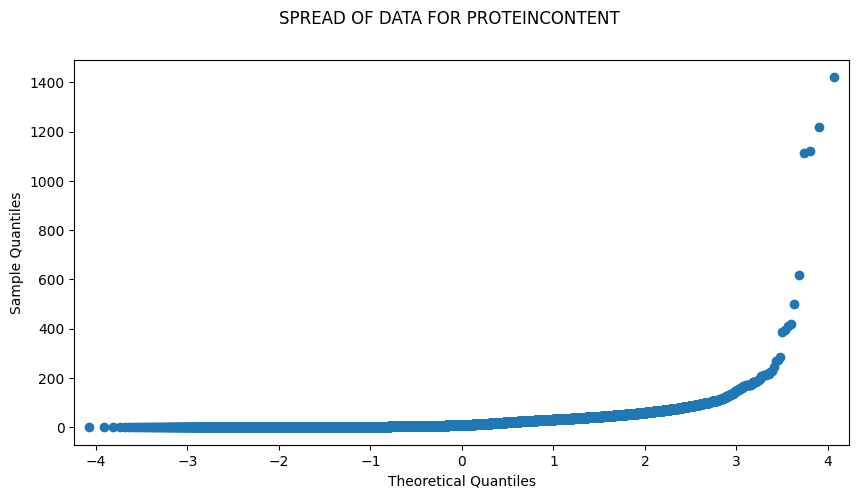

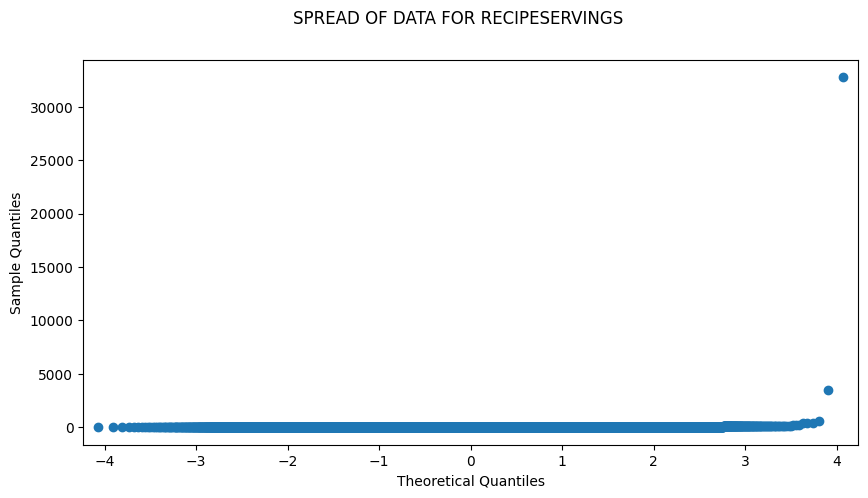

In [96]:
# Call qqplot function by iterating over numeric features
for i in range(len(numeric_columns)):
    qqplot(df[numeric_columns[i]])

Confirms all numeric features are right skewed with many observation at or near 0. Logx or boxcox transformation is needed to handle skewness with x+1 to handle values ranging from 0 to 1 to avoid negative numbers when transforming data. \

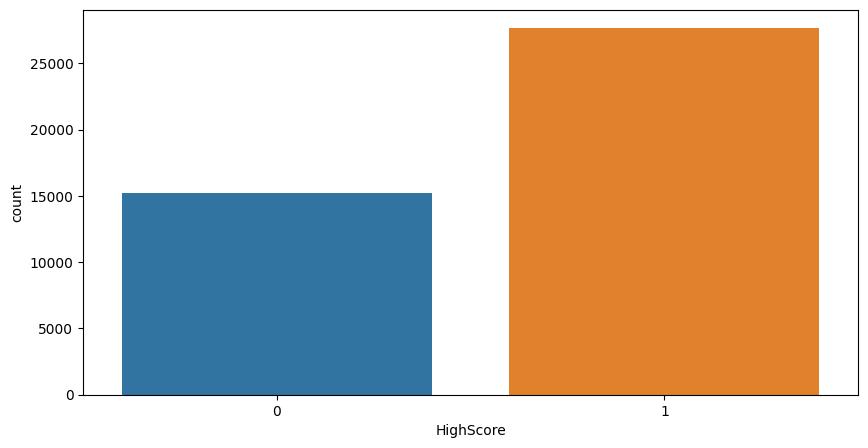

In [97]:
# Visualize target variable
sns.countplot(x=df['HighScore'])
plt.show()

Class imbalance: unequal distribution of classes with 1 almost having twice as many observations than 0

In [98]:
len(df["RecipeCategory"].unique())

246

Too many unique categories to convert into dummy variables. Need to map categories into more broad categories to reduce amount of categories. 

#### Outlier Treatment

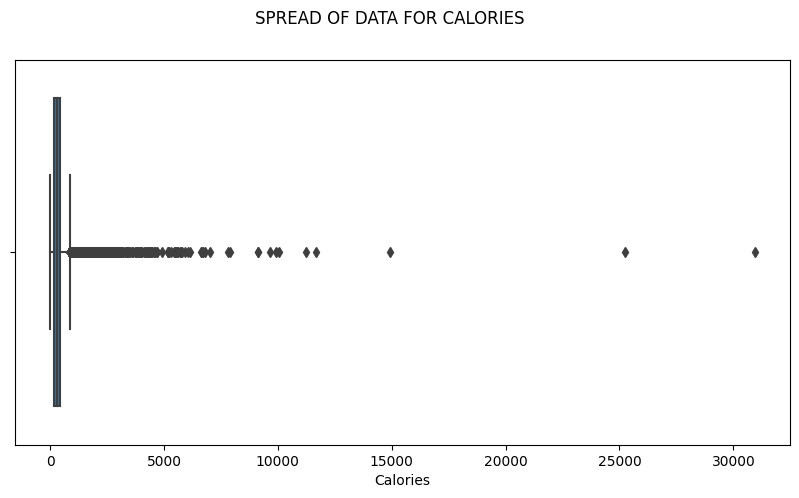

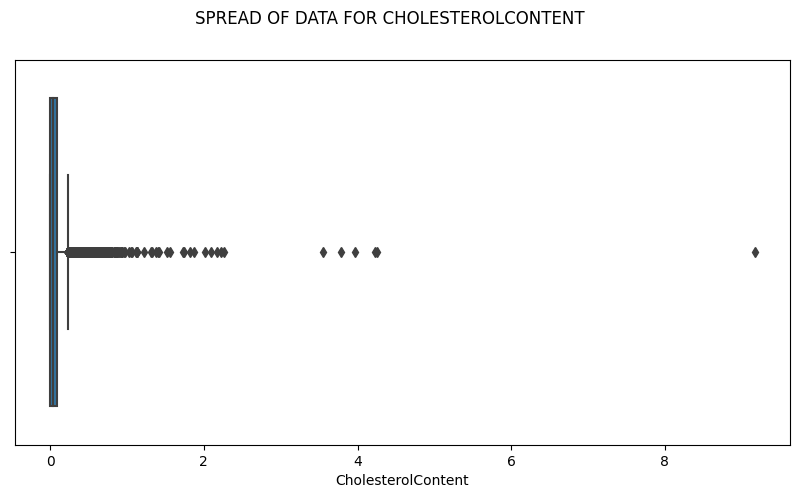

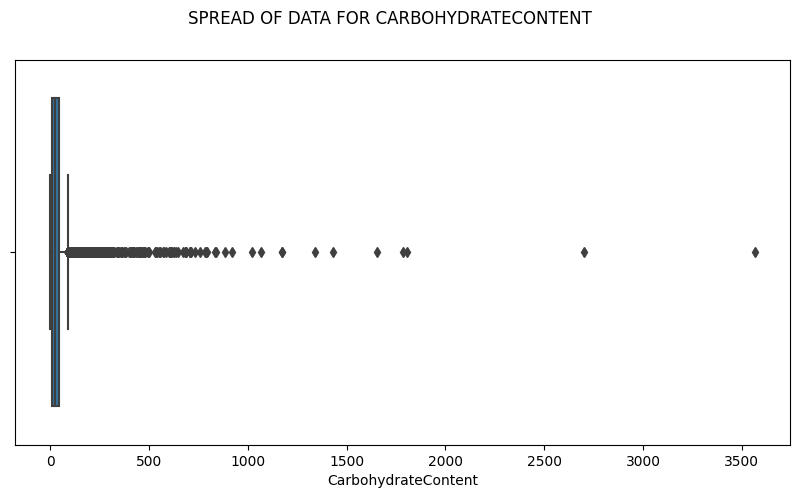

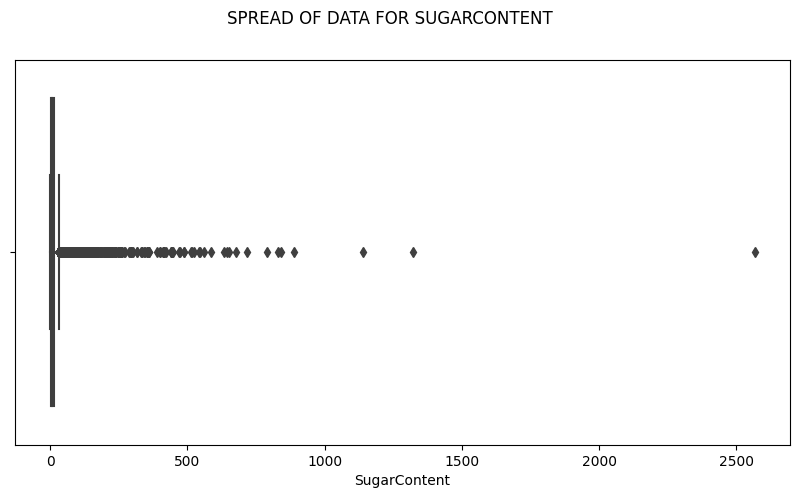

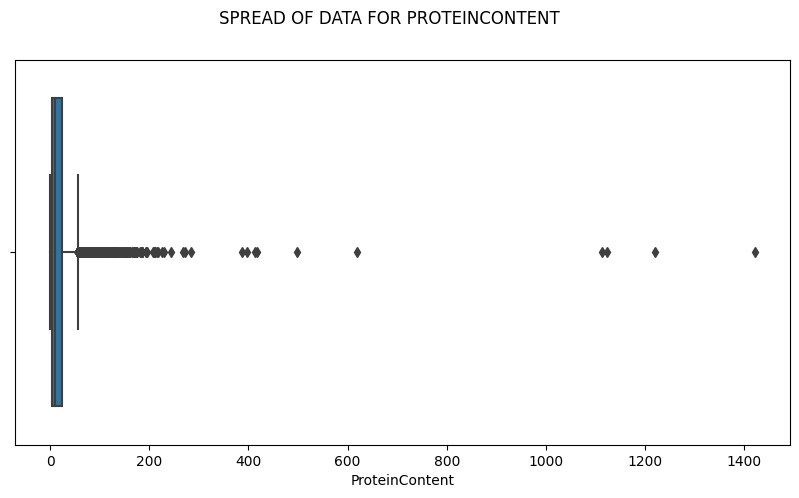

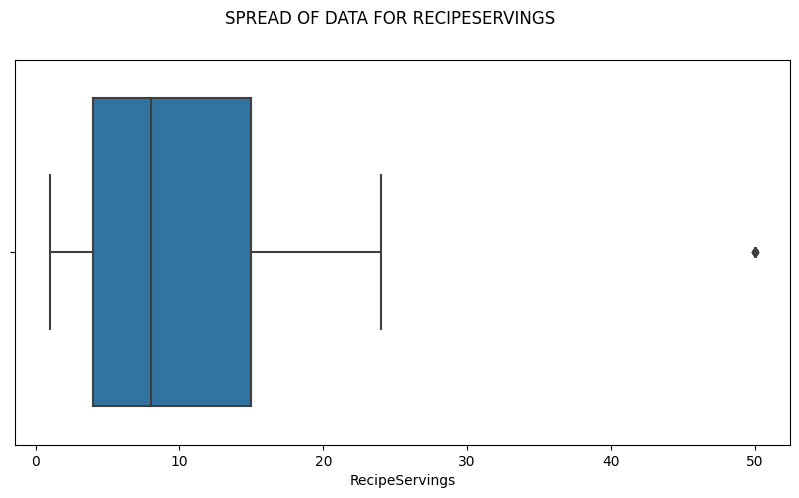

In [100]:
for i in range(len(numeric_columns)):
    box_plots(df[numeric_columns[i]])

Every feature has many outliers but they can not all be removed. Outliers will be removed based on distance from other outliers. If there are no near outliers near a value it will be removed. Can not use iqr because many observations will be removed that may have important information

In [101]:
# Find possible outliers in each feature
df.reset_index(drop=True, inplace=True)
# print highest value obersvations which are potential outliers
# print(df['CarbohydrateContent'].sort_values(ascending=False).head(20))
# print(df['SugarContent'].sort_values(ascending=False).head(20))
# print(df['ProteinContent'].sort_values(ascending=False).head(20))
# print(df['RecipeServings'].sort_values(ascending=False).head(20))

In [102]:
# display outliers
cals_rs = df[(df['Calories'] >= 1500) & (df['RecipeServings'] == 1)]
display(cals_rs.sort_values(by='Calories', ascending=False))

# remove outliers
index_cals = cals_rs.index
df.drop(index_cals, inplace=True) 

RecipeId                                            Name  \
35736      4341                           Hot Chocolate Dry Mix   
24729      3232                                My Sin (Dessert)   
27822    267015                      Maple Apple Roasted Turkey   
38735    195512                                   Pork Sandwich   
36852      7247                               Mattie's Jam Cake   
...         ...                                             ...   
25899    321719                       A&amp;w Chili Dog Copycat   
7504     450488                  Sweet &amp; Savory Spiced Nuts   
28947    309616                      Chicken and Rice Casserole   
30529    263200                                   Spicy Mustard   
694      197601  Shrimp Patricio, Shrimp Vesuvio, Shrimp Romano   

      RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
35736      Beverages   25248.7              3.9731               2700.9   
24729        Dessert   14945.6              3.5540                921.8   
27822         Animal   11670.9              4.2222                254.0   
38735   Lunch/Snacks   11249.0              4.2511                 39.4   
36852        Dessert    9642.9              1.0493               1787.7   
...              ...       ...                 ...                  ...   
25899   Lunch/Snacks    1555.4              0.3392                 78.0   
7504            Nuts    1551.8              0.0000                 59.6   
28947  One Dish Meal    1547.7              0.3055                176.3   
30529        Spreads    1543.2              0.3720                234.8   
694         European    1542.9              0.2765                 46.2   

       SugarContent  ProteinContent  RecipeServings  HighScore  
35736        2566.8          1122.6               1          1  
24729         634.8           185.4               1          0  
27822         174.1          1112.9               1          0  
38735           9.9          1420.8               1          1  
36852        1139.8           128.6               1          1  
...             ...             ...             ...        ...  
25899          39.6            98.7               1          0  
7504           38.6            18.3               1          1  
28947           2.4           131.6               1          0  
30529         208.6            42.1               1          1  
694            22.5            13.6               1          1  

[157 rows x 10 columns]

After inspection: \
Remove observations with 1500 calories or more with recipe serving of 1 

Reasoning: \
Chicken and rice casserole is a one dish meal which should be highest in calories since it is a full meal. This observation should have around 301 calories per serving but it shows 1547.7 calories in the data. After inspecting all other observations the conclusion is made to remove these outliers 

In [103]:
display(df.sort_values(by='Calories', ascending=False))
index_cals = df[df['Calories'] >= 3000].index
df.drop(index_cals, inplace=True)

RecipeId                                               Name  \
40127    148446                         Seasoned Goldfish Crackers   
26608    352050                             Zingy Chicken Stir-Fry   
31973     22729                               Dough for Fried Pies   
1396     536964                             Lasagna Grilled Cheese   
32541    202651  Lemon Grass Prawn (Shrimp) Skewers With Mango ...   
...         ...                                                ...   
41109    191595                            Homemade Herb Seasoning   
23424    293470                                    Black Margarita   
10119    180095                                         Moose Nose   
31704     57891                                       White Cactus   
29268    454100                        La Bou Creamy Dill Dressing   

      RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
40127       Friendly   30933.4              0.7961               3564.4   
26608  One Dish Meal   10057.1              2.1767               1804.3   
31973        Dessert    9916.5              0.0057                 49.6   
1396          Cheese    6682.7              0.1588               1174.2   
32541     Australian    6638.5              9.1672                 61.5   
...              ...       ...                 ...                  ...   
41109          Vegan       0.1              0.0000                  0.0   
23424      Beverages       0.1              0.0000                  0.0   
10119         Animal       0.1              0.0000                  0.0   
31704      Beverages       0.1              0.0000                  0.0   
29268   Cooking time       0.1              0.0000                  0.0   

       SugarContent  ProteinContent  RecipeServings  HighScore  
40127          17.2           618.6              10          1  
26608          68.2           387.8               2          1  
31973           0.2             7.8               6          0  
1396           61.0           272.8               4          1  
32541           5.5          1219.5               8          0  
...             ...             ...             ...        ...  
41109           0.0             0.0             100          0  
23424           0.0             0.0               1          0  
10119           0.0             0.0               6          0  
31704           0.0             0.0               1          0  
29268           0.0             0.0               2          1  

[42707 rows x 10 columns]

After inspection: \
Remove observations with 3000 calories or more \
Reasoning: \
El Farol Fried Calamari should have around 149 calories but in the data it shows 3733.9 calories for a serving of 6. Also Basic french toast should have around 149 calories per slice but in the data it shows 3133 calories for a serving of 4. Going below the 3000 calorie range some observations start to make sense due to the serving size being greater than 1. 

In [104]:
cholesterol_rs = df[(df['CholesterolContent'] >= 0.3) & (df['RecipeServings'] == 1)]
display(cholesterol_rs.sort_values(by='CholesterolContent', ascending=False))
index_cholesterol = cholesterol_rs.index
df.drop(index_cholesterol, inplace=True) 

RecipeId                                          Name RecipeCategory  \
33286    169714                                  Curried Eggs   Cooking time   
33893    274154                Tomato Basil Omelet (Low Carb)      Breakfast   
22982    182427            Philly Steak &amp; Cheese Omelette      Breakfast   
18493    110936                  Stolen Garlic Chicken Livers  One Dish Meal   
10457    526499                                         Omlet      Breakfast   
...         ...                                           ...            ...   
11365    115282                            Open Faced Reubens   Lunch/Snacks   
10920    114428           Jude's Grilled Ham and Egg Sandwich      Breakfast   
42777     90797                 Copycat Bob Evan's Cobb Salad   Cooking time   
8795       4240  Mashed Potato Casserole (Perunasoselaatikko)     Vegetables   
24269    202313                              Daikon Carbonara   Lunch/Snacks   

       Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
33286     839.6              1.3261                 29.4           6.3   
33893    1016.2              1.0597                  3.6           2.8   
22982    1188.7              0.8719                  7.7           3.5   
18493     403.8              0.7825                  5.0           0.2   
10457     589.8              0.7745                 19.3          10.9   
...         ...                 ...                  ...           ...   
11365    1297.7              0.3237                 49.4           7.9   
10920     840.9              0.3185                 77.9           2.0   
42777     385.7              0.3088                  5.8           1.1   
8795      780.4              0.3072                 89.5          12.4   
24269     450.6              0.3023                  9.2           4.8   

       ProteinContent  RecipeServings  HighScore  
33286            48.5               1          1  
33893            26.5               1          0  
22982            59.7               1          1  
18493            39.0               1          1  
10457            28.1               1          1  
...               ...             ...        ...  
11365            83.0               1          0  
10920            48.0               1          1  
42777            40.1               1          1  
8795             16.8               1          1  
24269            24.8               1          0  

[122 rows x 10 columns]

After inspection: \
Remove observations with 0.3 in cholesterol or higher with recipe serving of 1 

Reasoning: \
Grilled Cheese in a Nest should be high in cholesterol due to the cheese with around 0.034 grams but in the data it shows 0.3553 which is impossible. After inspecting all other observations the conclusion is made to remove these outliers 


In [105]:
display(df.sort_values(by='CholesterolContent', ascending=False))

RecipeId                                     Name     RecipeCategory  \
35647    339605                         Liver and Onions               Meat   
30088    268528        Kittencal's Beef Liver and Onions               Meat   
10990      7195                   Oven Style Scotch Eggs       Cooking time   
32663     42870   Luby's Cafeteria Beef Liver and Onions               Meat   
9268       7440      Sur Le Gril Chopped Calf Liver Pate               Meat   
...         ...                                      ...                ...   
27035     20173                       Chicago Hot Relish             Low of   
13693    105656                 Baked Apples and Bananas          Breakfast   
13694    316299                             Carob Halvah            Dessert   
13696     37772  Smoky Bean Salad With Molasses Dressing  Southwestern U.S.   
31412    308109                                   Hummus           European   

       Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
35647    1541.8              2.2610                 86.0           3.4   
30088    1444.2              2.2229                 80.4           7.0   
10990     987.5              1.7398                 25.9           6.3   
32663    1157.2              1.7278                 66.6           4.5   
9268      728.9              1.4054                 15.2           1.6   
...         ...                 ...                  ...           ...   
27035     769.4              0.0000                185.2         172.2   
13693     279.5              0.0000                 72.2          61.0   
13694     124.8              0.0000                 11.6           6.2   
13696     232.5              0.0000                 23.8           6.6   
31412     226.1              0.0000                 18.6           0.2   

       ProteinContent  RecipeServings  HighScore  
35647           170.4               2          1  
30088           169.2               4          1  
10990            69.4               8          1  
32663           133.1               6          1  
9268             81.8               4          0  
...               ...             ...        ...  
27035             7.9               8          1  
13693             1.0               4          1  
13694             3.6              12          1  
13696             5.9               6          1  
31412             5.8               8          0  

[42559 rows x 10 columns]

After inspection: 
No observations will be removed \
Reasoning: 
Due to recipe serving being greater than one the cholesterol content is possible in the higher range of the values.

In [106]:
carbs_rs = df[(df['CarbohydrateContent'] >= 160) & (df['RecipeServings'] == 1)]
display(carbs_rs.sort_values(by='CarbohydrateContent', ascending=False))
index_carbs = carbs_rs.index 
df.drop(index_carbs, inplace=True)

RecipeId                                               Name  \
16335    309671             Pork Tenderloin Marinade/Basting Sauce   
20220    102077                                  Pumpkin Pie Latte   
8269     255233                      Linda's Cream Cheese Frosting   
34680     83474                                      Coconut Candy   
7340     217430                            Play Dough -Gluten Free   
14263    111122                         Recipe for a Holiday Scent   
8487      24765                                      Caramel Icing   
24724    386826                         5-Spice Plum Glaze for Ham   
20569    366208                       Maui Teriyaki Sauce Marinade   
30682    132431  Fire Hot Chilli Paste (Sambal) - Indonesian Sauce   
18462    490458                      Pomegranate Syrup or Molasses   
22832      2335                            Collections (4) Tapioca   
20975    186301                                         Date Syrup   
37547      3455                                  Polenta Pizzarina   
7709       4834                           Cranberry Burgundy Sauce   
24527       611                              Fluffy White Frosting   
18845    466342                   Caramel Sweetened Condensed Milk   
20549    343222                                        Brown Sugar   
37687    373273                  Best Eggless Cookie Dough (For 1)   
42115     58014                  Red Apple - nonalcoholic cocktail   
7201     442917                 Melted Sugar Glue for Candy Houses   
23406    157184            Sazerac (The Big Easy's First Cocktail)   
15242    245558                                        Pizza Dough   
31714    452662                                      Udon Stir-Fry   
41234    197981                 Cherry Pineapple Holiday Ham Glaze   
19928    131067                                         Play Dough   
32356    457809                                           Kato Tea   
32755    400488          BBQ Sauce (Eugene's Dad's Barbecue Sauce)   
8125     360515                                           Melonade   
18578    420978                                    Asian Spaghetti   
25965    419251                                My Smokey BBQ Sauce   
34551    129883                   Corn, Black Bean and Mango Salsa   
9329     413823                                     Bay Leaf Sauce   
26423    320076                        Chocolate Malted Milk Shake   
10826     25190  Meal in a Bowl - Noodle Soup - for 1 Double fo...   
23263    361984                             Citrus Honey Ham Glaze   
23394    503301                          Caribbean Mist - Cocktail   
9685     275917                                  Udon Noodle Salad   
30101    123855                                        Beer Shandy   
35412      7163                              Sweet Potato Biscuits   

      RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
16335           Meat    1337.0              0.0000                337.1   
20220      Beverages    1465.1              0.0738                319.1   
8269         Dessert    1485.7              0.0957                302.3   
34680        Dessert    1161.0              0.0000                299.9   
7340        Friendly    1489.4              0.0000                275.2   
14263        Holiday    1062.4              0.0000                259.1   
8487         Dessert    1374.6              0.1418                234.7   
24724           Meat     962.9              0.0000                234.2   
20569         Low of    1036.2              0.0000                233.4   
30682          Asian     924.5              0.0000                232.8   
18462         Low of     928.1              0.0000                231.8   
22832        Dessert    1198.4              0.2391                226.8   
20975        Dessert     856.2              0.0000                225.2   
37547   Cooking time    1057.7              0.0000                220.7   
7709    Coo

After inspection: \
Remove observations with 0.3 in CarbohydrateContent or higher with recipe serving of 1 

Reasoning: \
A single date contains around 5.33 grams of carbs but in the data a serving of date candy has 785.2 which is too big of a jump to be logical. A homemade apple crumble contains about 60.8 grams of carbs but in the data a baked apple crumble has 280.5 carbs. In asain noodles gets most of its calories from carbs and should have 40 grams but in the data it has 180.7. A black bean, corn and mango salsa has around 18 grams per serving but in the data it shows Corn, Black Bean, and Mango salsa has 180.1 grams. A banana split should have around 159g of carbs and in the data it shows 153.4 which is possible. Above 160 carbs most observation become illogical. 


In [107]:
display(df.sort_values(by='CarbohydrateContent', ascending=False))
index_carbs = df[df['CarbohydrateContent'] >= 700].index
df.drop(index_carbs, inplace=True)

RecipeId                                            Name  \
30074    505619                              Pineapple Daiquiri   
1910      12972  Rich chocolate mousse with dark fruit surprise   
37605     94454                         Chinese Style Spaghetti   
27291    326591                      Golden Syrup Russian Fudge   
37997    240605                             Frozen Green Grapes   
...         ...                                             ...   
37909    297466                                         220 Btu   
28503    456242                                  Oven Kalua Pig   
24925    158084                              Godmother Cocktail   
10981    142945                                Breadstick Bones   
19074    309526                               Island Girl Drink   

      RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
30074      Beverages    1918.9              0.0000                478.4   
1910         Dessert    2520.2              0.8860                465.3   
37605  One Dish Meal    2349.0              0.0000                458.9   
27291        Dessert    2265.5              0.1761                433.1   
37997   Lunch/Snacks    1580.5              0.0000                414.5   
...              ...       ...                 ...                  ...   
37909      Beverages     131.0              0.0000                  0.0   
28503           Meat     503.5              0.1497                  0.0   
24925      Beverages     138.7              0.0000                  0.0   
10981   Lunch/Snacks       4.2              0.0013                  0.0   
19074      Beverages     104.2              0.0000                  0.0   

       SugarContent  ProteinContent  RecipeServings  HighScore  
30074         358.9            19.6               2          1  
1910          269.3            51.4               4          1  
37605          18.7            85.5               4          0  
27291         413.1            10.4               2          1  
37997         355.0            16.3               2          1  
...             ...             ...             ...        ...  
37909           0.0             0.0               1          0  
28503           0.0            42.5               6          1  
24925           0.0             0.0               1          1  
10981           0.0             0.0              24          0  
19074           0.0             0.0               1          1  

[42519 rows x 10 columns]

After inspection: \
Remove observations with 700 carbs or more \
Reasoning: \
Only observation removed is 1174.2 carbs for lasagna grilled cheese for a serving of 4 which is illogical.

In [108]:
sugar_rs = df[(df['SugarContent'] >= 100) & (df['RecipeServings'] == 1)]
display(sugar_rs.sort_values(by='SugarContent', ascending=False))
index_sugar = sugar_rs.index
df.drop(index_sugar, inplace=True)

RecipeId                                             Name  \
11539    196354                                          Ice Tea   
5056     502164                Thai Sweet Chili Sauce - Homemade   
13101    441787                       Honey Rosewater Sugarscrub   
23091    470621                          Jiffy Mix Sugar Cookies   
22324    418827                                  Chocolate Icing   
9160     438525  Cinnamon Roll Glaze from My Taste of Facs Class   
38210     10045                               strawberry filling   
19055    270393                  Copycat Applebees Peach Sangria   
7195     182985                               Watermelon Martini   
19953    404365                                 Peppermint Mocha   
2978     420092                        Cranberry Cooler Smoothie   
26939    539095                                   The Soul Train   

      RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
11539      Beverages     600.8              0.0000                157.0   
5056          Sauces     605.6              0.0000                155.7   
13101    Bath/Beauty     607.9              0.0000                142.0   
23091        Dessert    1217.6              0.1974                138.0   
22324        Dessert    1021.8              0.1220                128.3   
9160          Sauces     747.7              0.0815                119.9   
38210        Dessert     578.4              0.0000                145.9   
19055      Beverages     486.8              0.0000                127.1   
7195       Beverages     622.4              0.0000                130.8   
19953      Beverages     767.5              0.0512                137.5   
2978       Smoothies     542.8              0.0000                131.6   
26939      Beverages     402.6              0.0000                104.0   

       SugarContent  ProteinContent  RecipeServings  HighScore  
11539         151.8             0.3               1          0  
5056          150.1             0.6               1          0  
13101         141.9             0.0               1          1  
23091         133.8             8.9               1          1  
22324         118.0             4.1               1          0  
9160          117.9             0.3               1          1  
38210         117.4             2.5               1          1  
19055         108.7             4.7               1          1  
7195          106.6            10.5               1          0  
19953         105.1            17.8               1          0  
2978          104.0             2.9               1          1  
26939         102.8             0.2               1          1

After inspection: \
Remove observation with 100 grams of sugar or more with recipe serving of 1 \
Reasoning: 
Peppermint mocha should have around 54g of total sugar but in the data it has 105.1 which is not impossible but not likely. So cut of will be above 100g of sugar per single serving. 

In [109]:
sugar = df[df['SugarContent'] >= 300]
display(sugar.sort_values(by='SugarContent', ascending=False))

RecipeId                                     Name RecipeCategory  \
27291    326591               Golden Syrup Russian Fudge        Dessert   
30074    505619                       Pineapple Daiquiri      Beverages   
37997    240605                      Frozen Green Grapes   Lunch/Snacks   
18882    117485                     Tomato Raspberry Jam         Low of   
12612    133604  Roadhouse Grill Texas Egg Rolls Copycat         Low of   

       Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
27291    2265.5              0.1761                433.1         413.1   
30074    1918.9              0.0000                478.4         358.9   
37997    1580.5              0.0000                414.5         355.0   
18882    1446.3              0.0000                365.5         352.5   
12612    1856.5              0.0727                405.1         331.3   

       ProteinContent  RecipeServings  HighScore  
27291            10.4               2          1  
30074            19.6               2          1  
37997            16.3               2          1  
18882             9.4               3          1  
12612            16.4               4          1

After inspection: 
No observations will be removed \
Reasoning: 
Due to recipe serving being greater than one the sugar content is possible in the higher range of the values.

In [110]:
protein_rs = df[(df['ProteinContent'] >= 70) & (df['RecipeServings'] == 1)]
display(protein_rs.sort_values(by='ProteinContent', ascending=False))
index_protein = protein_rs.index
df.drop(index_protein, inplace=True)

RecipeId                                Name RecipeCategory  Calories  \
30398    439201  P90x Chicken Salad&ndash;level IIi   Lunch/Snacks    1099.6   
10847      4729                     Wonton Soup III          Asian    1129.5   
4688     167384             Victor's Cuban Sandwich   Lunch/Snacks     821.5   
31002    123732      Rocket Pops! Layered Popsicles        Dessert     668.4   

       CholesterolContent  CarbohydrateContent  SugarContent  ProteinContent  \
30398              0.1814                 65.2          11.8           110.4   
10847              0.2404                135.3           8.7            90.5   
4688               0.2303                  7.6           2.2            79.0   
31002              0.0000                100.0          99.8            71.9   

       RecipeServings  HighScore  
30398               1          0  
10847               1          1  
4688                1          0  
31002               1          0

After inspection: \
Remove observations with 70 grams of protein or more with recipe serving of 1 \
Reasoning: \
4 observations given in this range are not logical

In [111]:
protein = df[df['ProteinContent'] >= 250]
display(protein.sort_values(by='ProteinContent', ascending=False))
index_protein = protein.index
df.drop(index_protein, inplace=True) 

RecipeId                         Name RecipeCategory  Calories  \
25749    439202  P90x Island Pork Tenderloin         Low of    2501.1   

       CholesterolContent  CarbohydrateContent  SugarContent  ProteinContent  \
25749               1.313                 14.5          13.4           417.4   

       RecipeServings  HighScore  
25749               4          1

After inspection: \
Observations above 250 protein will be removed
Reasoning: 
1 observations has 250 grams or more. Even with a serving size of 4, 417.4 grams of protein is not possible for P90x Island Pork Tenderloin. It should have around 31.7 grams per serving.

In [112]:
rs = df[df['RecipeServings'] >= 20]
display(rs.sort_values(by='RecipeServings', ascending=False))

RecipeId                                           Name RecipeCategory  \
13096     72549                              Alaskan Blue Stew     Thick Soup   
38459     19866                                  Elephant Stew           Meat   
5388     490620           Coffee Ice Cream and Cookie Parfaits        Dessert   
7876     201663                             Oven Fried Chicken         Animal   
23277    373997  Thum -- Garlic Sauce (Lebanon -- Middle East)         Sauces   
...         ...                                            ...            ...   
24908    431403                         Healthy Hot Cereal Mix      Breakfast   
24995     37586                 Clam Chowder - Westcoast Style     Thick Soup   
25037    409600                    Flavorful, Filling, Granola      Breakfast   
25221     35348           Chocolaty Peanut Butter Banana Bread         Breads   
21633     85936                               Beer Cheese Logs   Lunch/Snacks   

       Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
13096     127.5              0.0059                 27.1           3.7   
38459       3.9              0.0002                  0.4           0.3   
5388        1.4              0.0002                  0.2           0.2   
7876        2.9              0.0010                  0.0           0.0   
23277       1.6              0.0000                  0.0           0.0   
...         ...                 ...                  ...           ...   
24908     107.8              0.0000                 14.0           0.3   
24995     207.4              0.0266                 23.9           7.9   
25037     328.3              0.0000                 63.6          14.9   
25221     162.5              0.0194                 24.9          12.9   
21633     149.8              0.0428                  1.1           0.1   

       ProteinContent  RecipeServings  HighScore  
13096             5.3           32767          0  
38459             0.3            3500          1  
5388              0.0             610          1  
7876              0.2             410          1  
23277             0.0             406          1  
...               ...             ...        ...  
24908             4.8              20          1  
24995            11.8              20          1  
25037            12.3              20          1  
25221             4.1              20          0  
21633             6.0              20          0  

[2930 rows x 10 columns]

After inspection: \
Drop all of recipe serving content \
Reasoning: \
The recipe serving do not make sense. For example a serving size of 24 for a dessert that only has 78.9, 13.8, 69.8, 79.8, and 50.7 calories which for a dessert is very low. Many observations are worse than this for example for a serving size of 100 a dessert only has 48.9, 59.5, 49, 50.2 calories which is impossible. With most observations like this it will confuse the model and there seems to be no pattern in order to fix this feature. 

In [113]:
# Check skew value of numeric features
print('Calories skew value: ', df['Calories'].skew())
print('Carbs skew value: ',df['CarbohydrateContent'].skew())
print('Proteins skew value: ',df['ProteinContent'].skew())
print('Cholesterols skew value: ',df['CholesterolContent'].skew())
print('Sugars skew value: ',df['SugarContent'].skew())

Calories skew value:  2.244426099019736
Carbs skew value:  2.6540067488138552
Proteins skew value:  2.189934193622687
Cholesterols skew value:  3.5147904717012155
Sugars skew value:  4.736257270535085


Features are still skewed. 

In [114]:
# transform models
cals_transformed, _ = stats.boxcox(df["Calories"] + 1)
df["Calories"] = cals_transformed
df['ProteinContent'] = df['ProteinContent'] ** 0.5
df['CarbohydrateContent'] = df['CarbohydrateContent'] ** (0.5)
cholesterol_transformed, _ = stats.boxcox(df["CholesterolContent"] + 1)
df["CholesterolContent"] = cholesterol_transformed
df['SugarContent'] = df['SugarContent'] ** (0.5)

In [115]:
# Check skew values again after transformation
print('Calories skew value: ', df['Calories'].skew()) 
print('Carbs skew value: ',df['CarbohydrateContent'].skew()) 
print('Proteins skew value: ',df['ProteinContent'].skew()) 
print('Cholesterols skew value: ',df['CholesterolContent'].skew()) 
print('Sugars skew value: ',df['SugarContent'].skew())  

Calories skew value:  0.038163716951167964
Carbs skew value:  0.491412274539557
Proteins skew value:  0.6322009404513587
Cholesterols skew value:  0.3201825928401631
Sugars skew value:  1.29351382052732


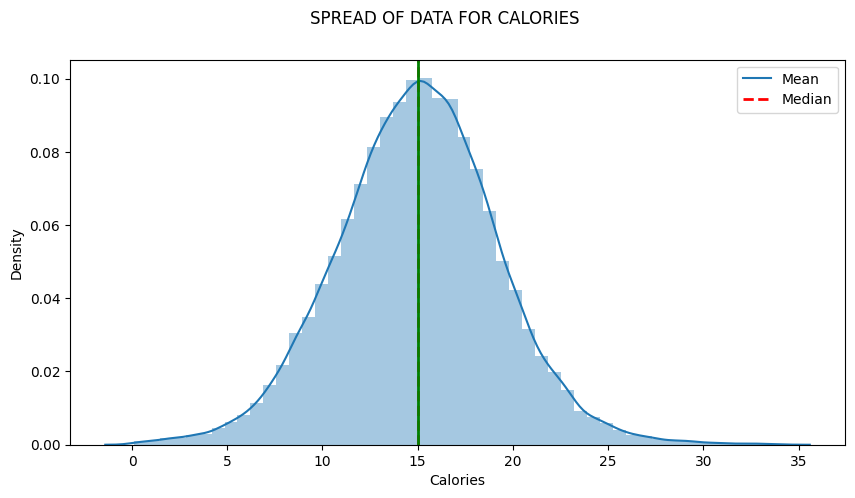

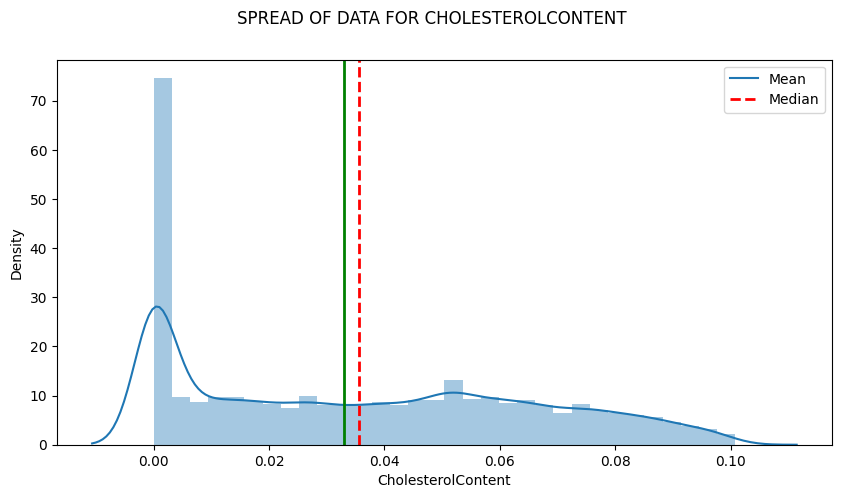

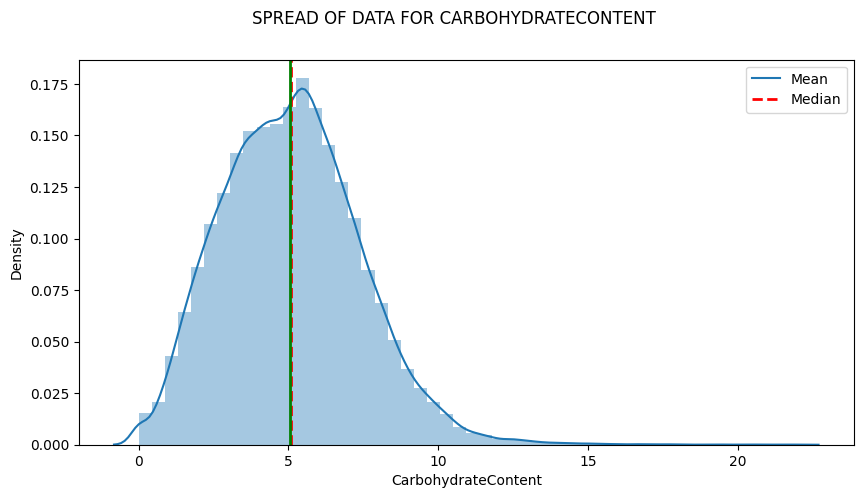

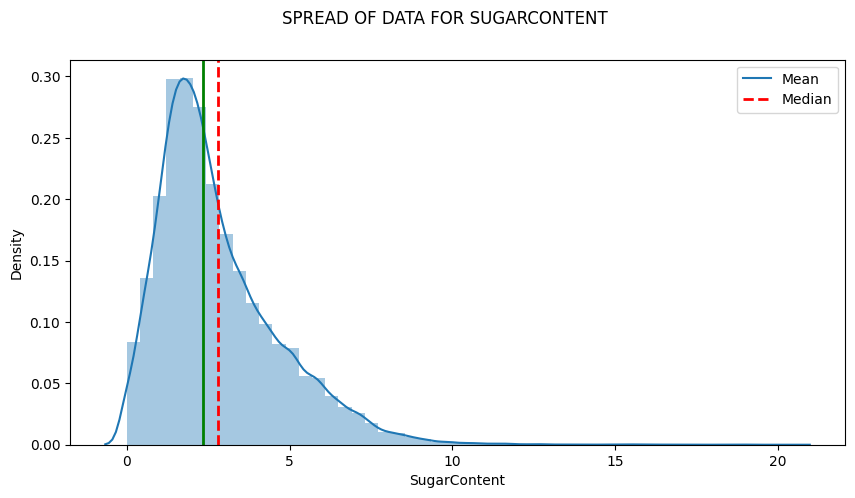

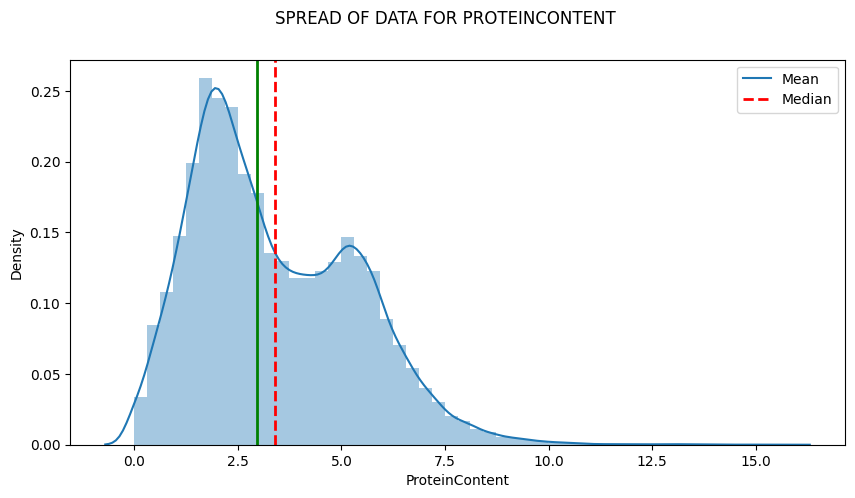

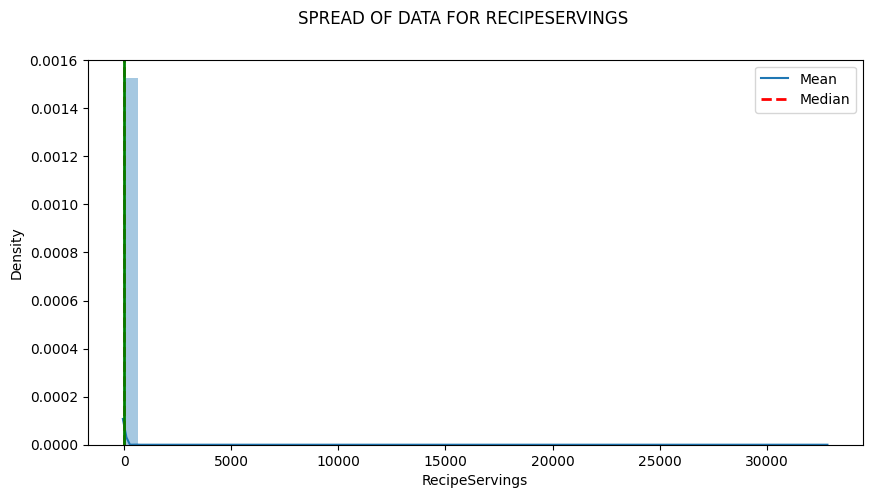

In [116]:
for i in range(len(numeric_columns)):
    dist_plots(df[numeric_columns[i]])

Features look more normal after transforming to fix right skew issue. 

#### Class imbalance

In [117]:
# Seperate features from target variable
X = df.drop(['HighScore', 'RecipeServings'], axis=1)
y = df['HighScore']

print(f'Original target data count: \n{y.value_counts()}')
# perform random over sampling with replacement
over_sample = RandomOverSampler(sampling_strategy='minority', random_state=100)
X_over, y_over = over_sample.fit_resample(X, y)
print(f'Target data count after sampling: \n{Counter(y_over)}')

Original target data count: 
1    27412
0    15090
Name: HighScore, dtype: int64
Target data count after sampling: 
Counter({1: 27412, 0: 27412})


In [118]:
df = X_over
df['HighScore'] = y_over
print(f'Dataframe shape after balancing class: {df.shape}')

Dataframe shape after balancing class: (54824, 9)


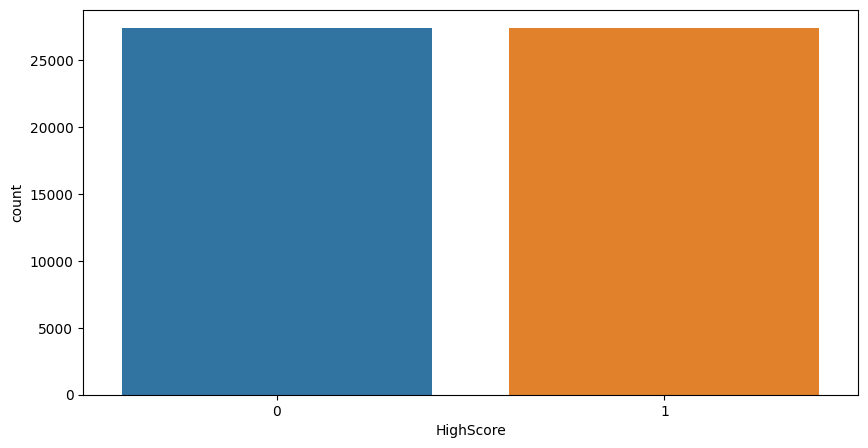

In [119]:
# Visualize target variable after balancing
sns.countplot(x=df['HighScore'])
plt.show()

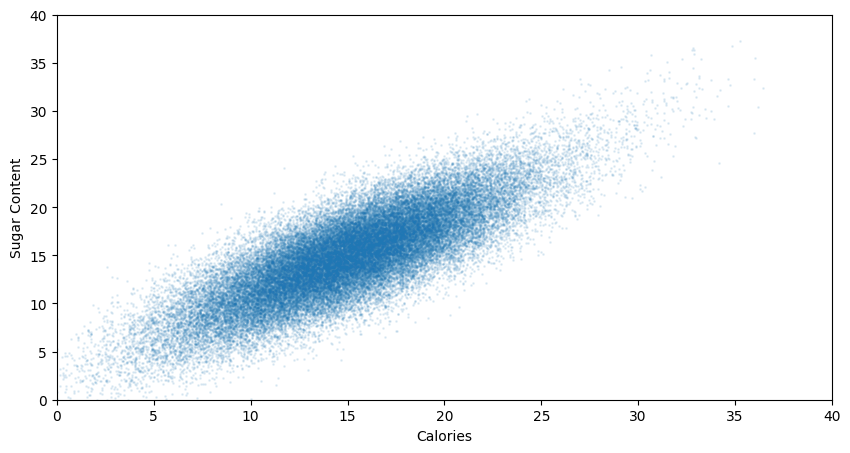

In [120]:
# visualize relationship between 2 features
cals = df['Calories']
carbs = df['SugarContent']
cals_jitter = cals + np.random.normal(0, 2, size=len(df))
carbs_jitter = cals + np.random.normal(0, 2, size=len(df))
plt.plot(cals_jitter, carbs_jitter, 'o', markersize=1, alpha=0.1)
plt.xlabel('Calories')
plt.ylabel('Sugar Content')
plt.rcParams['figure.figsize'] = (5, 5)
plt.axis([0,40,0,40])
plt.show()

Plot shows there might be a linear relationship between calories and sugarcontent. It seems as calories increases so does sugarcontent

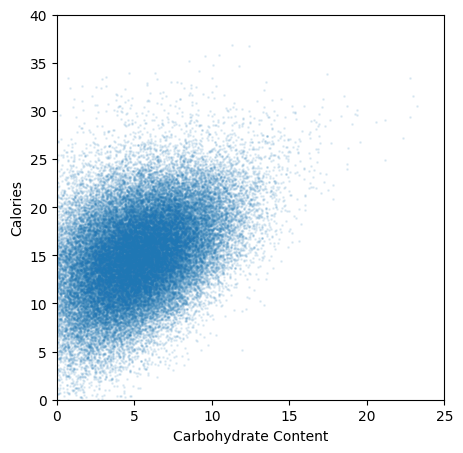

In [121]:
# visualize relationship between 2 features
protein = df['CarbohydrateContent']
cholesterol = df['Calories']
protein_jitter = protein + np.random.normal(0, 2, size=len(df))
cholesterol_jitter = cholesterol + np.random.normal(0, 2, size=len(df))
plt.plot(protein_jitter, cholesterol_jitter, 'o', markersize=1, alpha=0.1)
plt.xlabel('Carbohydrate Content')
plt.ylabel('Calories')
plt.rcParams['figure.figsize'] = (5, 5)
plt.axis([0,25,0,40])
plt.show()

Not a strong linear relationship is shown between calories and carbohydrate. There are many observation towards the top left that show a linear relationship as not the best option for a model.

In [122]:
# # Make dummy variables 
df = pd.get_dummies(df, columns=["RecipeCategory"], drop_first=True)

In [123]:
# seperate features and target variable
# X = df[['Calories', 'CarbohydrateContent', 'CholesterolContent', 'ProteinContent', 'SugarContent', 'RecipeServings']]
X = df.drop(['HighScore', 'Name', 'RecipeId'], axis=1)
y = df["HighScore"]

In [124]:
# split data into 30% test size and 70% train size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100, stratify=y)

Since each observation is labeled with either 0 or 1 this makes this problem a binary classification. For a base model logistic regression will be used which assumes there is a linear relationship in the data. 

In [125]:
model = LogisticRegression(random_state=300)
model.fit(X_train, y_train)

print('Accuracy of LogisticRegression on training set: {:.2f}'
     .format(model.score(X_train, y_train)))
print('Accuracy of LogisticRegression on test set: {:.2f}'
     .format(model.score(X_test, y_test)))

Accuracy of LogisticRegression on training set: 0.54
Accuracy of LogisticRegression on test set: 0.54


In [126]:
# get model predictions
predictions_lr = model.predict(X_test)

In [127]:
# print confusion matrix
conf_matrix_lr = confusion_matrix(y_test, predictions_lr)
print(conf_matrix_lr)

[[4502 3722]
 [3815 4409]]


In [128]:
TN = conf_matrix_lr[0, 0] 
FP = conf_matrix_lr[0, 1] 
FN = conf_matrix_lr[1, 0] 
TP = conf_matrix_lr[1, 1] 

In [129]:
an = TN / (TN + FN)
print(f'Accuracy on all low scoring recipes: % {round(an * 100, 2)}')

Accuracy on all low scoring recipes: % 54.13


Since there is more categorical data than numeric and the data still consist of outliers it affects the way a logistic model learns in a negative way. The model is correctly predicting 54 percent of the test data which shows a logistic regression is not the appropiate model to use. 

In [130]:
# getting feature importance
importance = model.coef_.flatten()

In [131]:
df[df['RecipeCategory_Spreads'] == 1]

RecipeId                                              Name   Calories  \
30         8929                               Carol's Muffalletto   5.828538   
305      417948                              Smoked Salmon Spread  11.098366   
441      297179                                Blue Cheese Spread  12.185410   
467      208096                               Curried Cheese Pate  13.814377   
494      189827  Chicken Liver Pate: Terrine De Foies De Volaille  14.630314   
...         ...                                               ...        ...   
52586    243754                        Vera's Green Tomato Relish   7.575256   
53122    103368                                     Hoagie Spread  15.492386   
53285     33307                  Deviled Ham &amp; Egg Spread/Dip  10.674788   
53601    116810                           Deviled Ham Cheese Ball  16.236789   
54514    318774                             Pimento Cheese Spread  14.168831   

       CholesterolContent  CarbohydrateContent  SugarContent  ProteinContent  \
30               0.000000             0.948683      0.447214        0.447214   
305              0.030031             1.264911      1.000000        2.366432   
441              0.023560             1.760682      1.048809        2.236068   
467              0.036277             1.949359      1.000000        2.664583   
494              0.093748             2.258318      1.095445        3.834058   
...                   ...                  ...           ...             ...   
52586            0.000000             3.286335      3.082207        1.000000   
53122            0.041422             3.033150      2.024846        3.885872   
53285            0.058154             1.183216      0.632456        2.428992   
53601            0.048701             2.302173      1.048809        3.271085   
54514            0.039606             2.549510      1.549193        2.738613   

       HighScore  RecipeCategory_Animal  RecipeCategory_Appliance  ...  \
30             1                      0                         0  ...   
305            0                      0                         0  ...   
441            1                      0                         0  ...   
467            1                      0                         0  ...   
494            1                      0                         0  ...   
...          ...                    ...                       ...  ...   
52586          0                      0                         0  ...   
53122          0                      0                         0  ...   
53285          0                      0                         0  ...   
53601          0                      0                         0  ...   
54514          0                      0                         0  ...   

       RecipeCategory_Southwestern U.S.  RecipeCategory_Soy/Tofu  \
30                                    0                        0   
305                                   0                        0   
441                                   0                        0   
467                                   0                        0   
494                                   0                        0   
...                                 ...                      ...   
52586                                 0                        0   
53122                                 0                        0   
53285                                 0                        0   
53601                                 0                        0   
54514                                 0                        0   

       RecipeCategory_Spice  RecipeCategory_Spreads  RecipeCategory_Stocks  \
30                        0                       1                      0   
305                       0                       1                      0   
441                       0                       1                      0   
467                       0                       1                

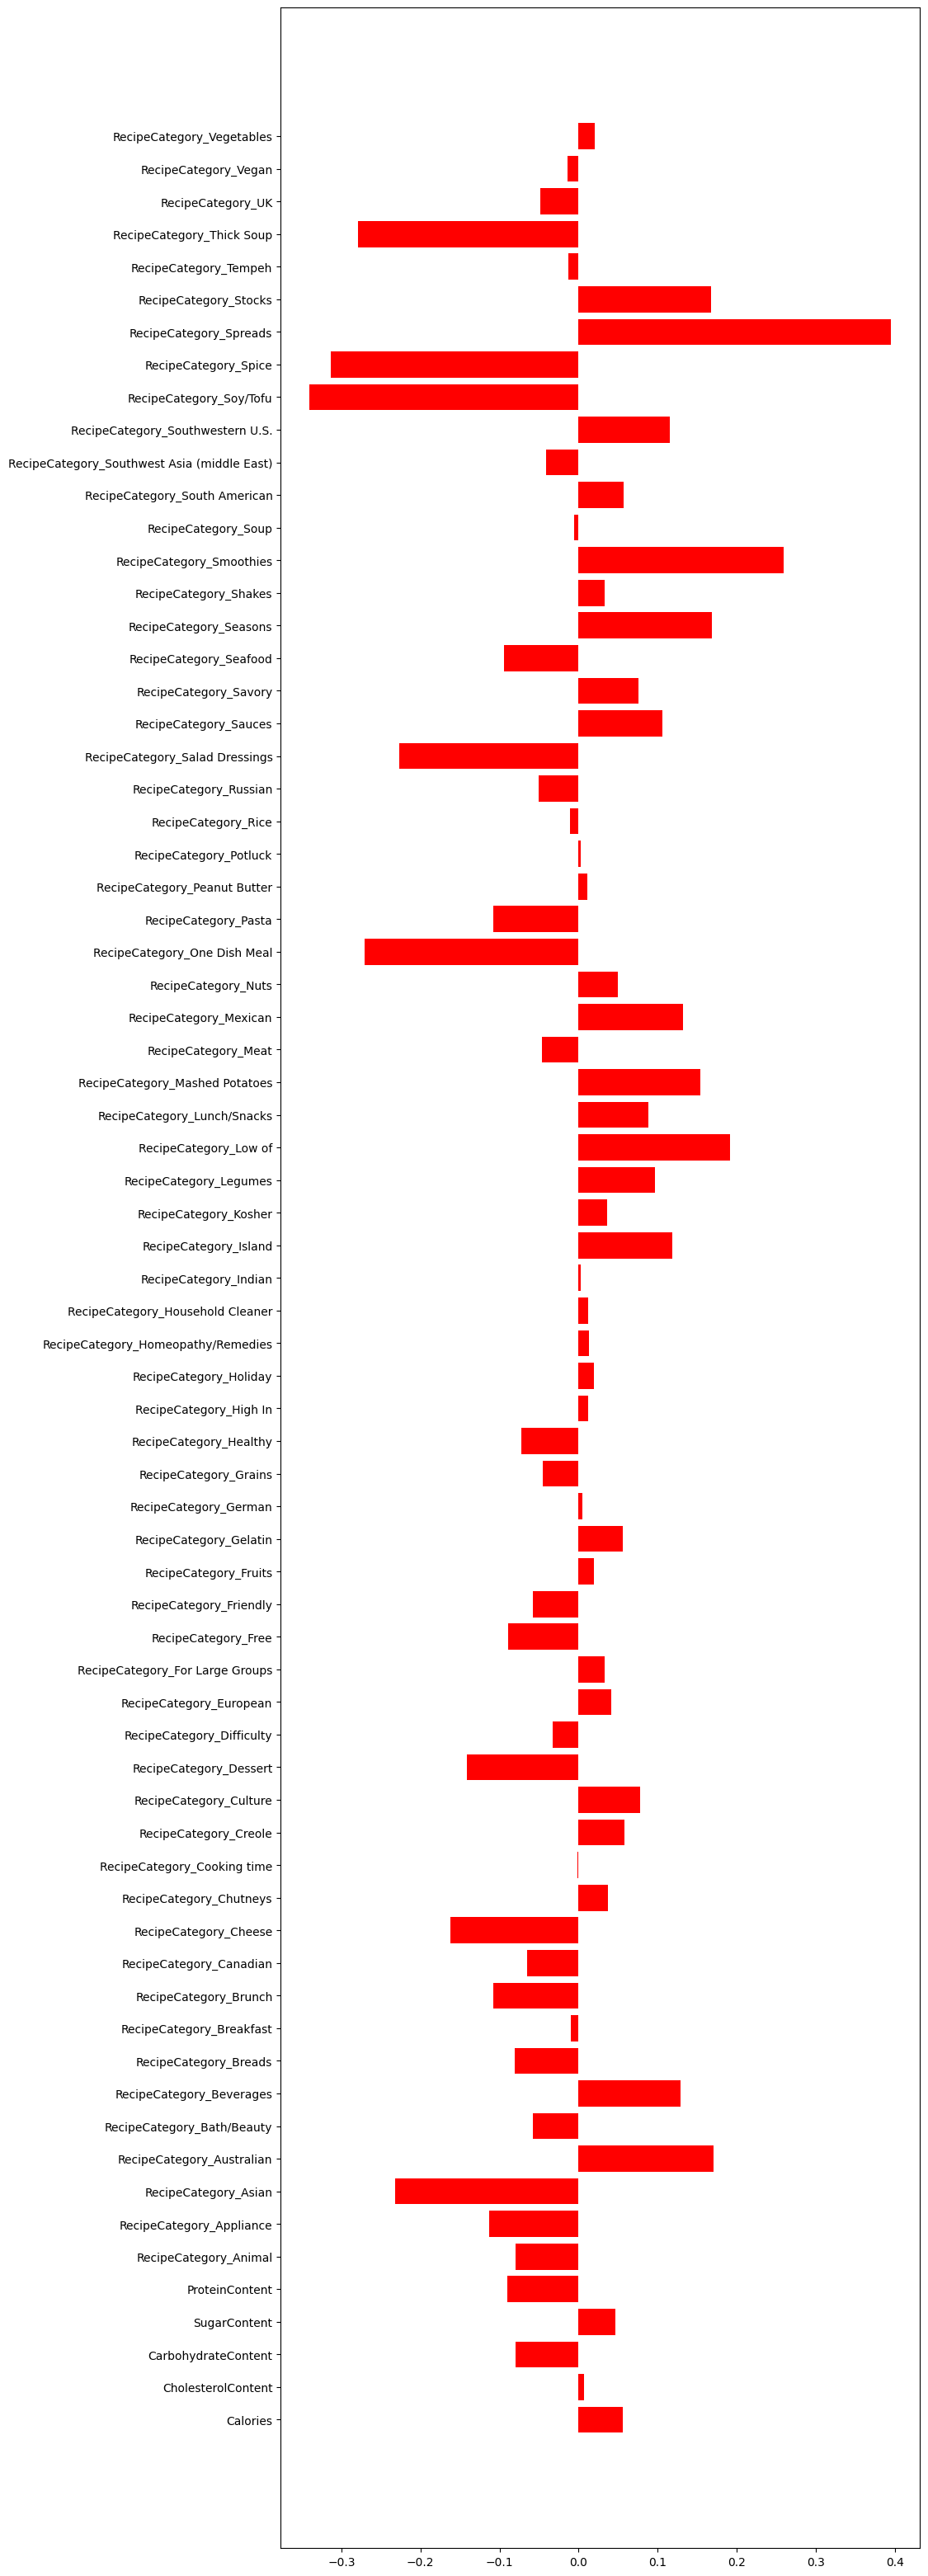

In [132]:
plt.rcParams['figure.figsize'] = (10, 40)
plt.barh(X.columns, importance, color='r')
plt.show()

Many of categorical features are of little importance which does not help the model learn. More outliers will have to be removed and feature reduction has to be achieved to improve model performance but important data might be lost if data keeps on being removed. \
Instead a new model will be used that can weight certain features as more important than others and does not need the data to have a linear relationship. Random Forest Classifier(RFC) is an ensemble learning model that might find non linear patterns in the data. RFC focuses more on accuracy when learning from the data, and it can capture more complex patterns in features by randomly selecting samples in individual decision trees to get the best accuracy. 

In [133]:
model = RandomForestClassifier(n_estimators=250, class_weight={0:0.99, 1:0.01}, random_state=150).fit(X_train, y_train)

print('Accuracy of RandomForestClassifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))

Accuracy of RandomForestClassifier on training set: 1.00
Accuracy of RandomForestClassifier on test set: 0.79


In [134]:
score = model.score(X_test, y_test)
print(f'Model accuracy of: % {round(score * 100, 2)}')

Model accuracy of: % 78.55


In [135]:
# get model predictions
predictions = model.predict(X_test)

In [136]:
# print confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[6969 1255]
 [2273 5951]]


In [137]:
TN = conf_matrix[0, 0] 
FP = conf_matrix[0, 1] 
FN = conf_matrix[1, 0] 
TP = conf_matrix[1, 1] 

In [138]:
# True negative rate
sp = TN / (TN + FP) 
print(f'True negative rate: % {round(sp * 100, 2)}')

True negative rate: % 84.74


In [139]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
print(f'Recall score / True positive rate: % {round(recall_score(y_test,predictions) * 100, 2)}')

Recall score / True positive rate: % 72.36


In [140]:
an = TN / (TN + FN)
print(f'Accuracy on all low scoring recipes: % {round(an * 100, 2)}')

Accuracy on all low scoring recipes: % 75.41


In [141]:
importances = model.feature_importances_
# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = df.columns[1:]

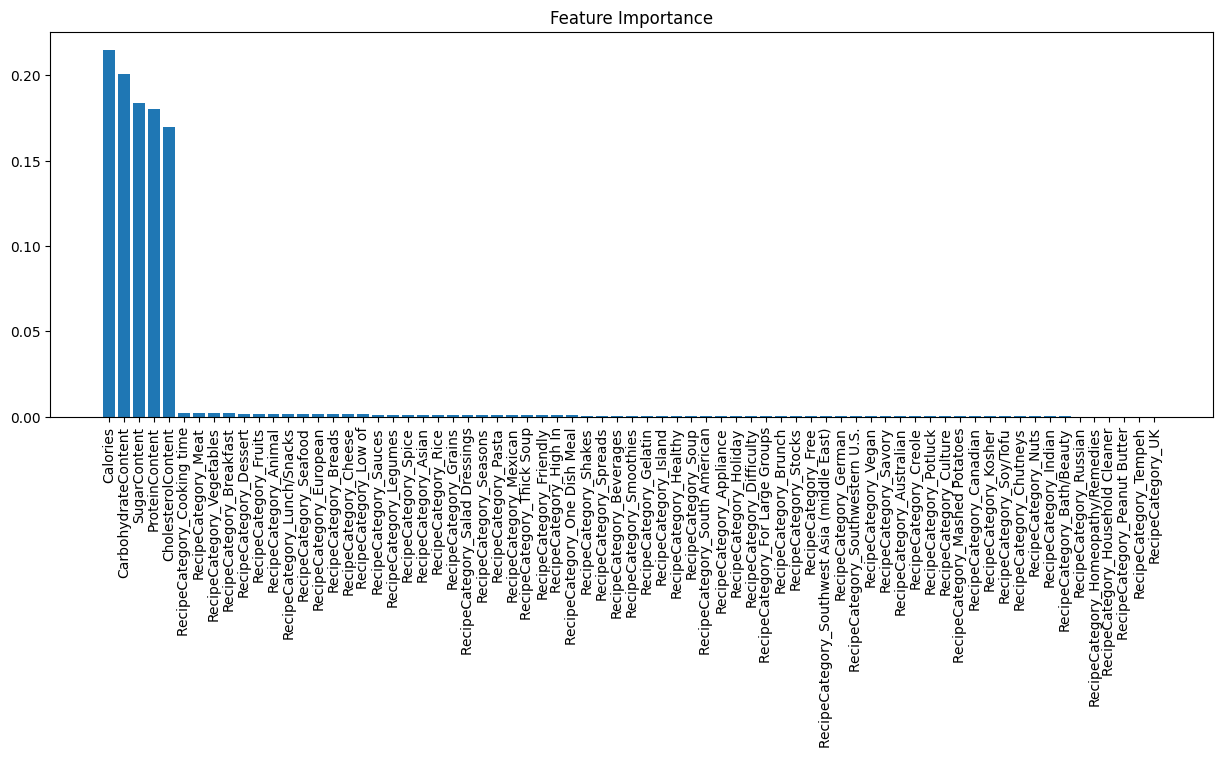

In [160]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
# plt.tight_layout()

plt.rcParams['figure.figsize'] = (15, 5)
plt.show()

RFC performs better than logistic regression due to the fact there are still outliers that can not be removed and many categorical features. RFC has a model accuracy of 78.55 % while logistic regression model has a accuracy of 54% on the test data. This shows the data has complex patterns that logistic regression can not pick up due to outliers\
Conclusion: \
The model can correctly predict 75.41% of all low scoring recipes in the test data with a total accuracy of 78.55 %. With this model Tasty Bytes can predict if a new recipe is a low scoring or high scoring recipe 78.55 % of the time. \
Improvement: \
The data contained many outliers. When collecting data if an observation is not logical raise a flag and have the observation double checked before being put into the data. For example if an observation has 3,000 calories or more and a recipe serving of 1 flag the observation before putting it into the data. \
Also having more important features in the data that can help with finding more patterns. For example collect data on how many ingridents are used in the recipe \ 